# Capstone 0 Prototype 
**Overview**: Initial capstone prototype 


In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error, mean_absolute_error
#, root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
set_config(display="diagram")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa import arima_process
from statsmodels.datasets import nile
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA





from matplotlib.pylab import rcParams
 
from statsmodels.tsa.stattools import adfuller
# !pip install pmdarima -q
import pmdarima as pm
#from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller




### Load data



In [4]:
df0 = pd.read_csv('data/historicalemshourlyloadfor2023.csv')
print(df0.head())

     Date  HR      PGE      SCE     SDGE    VEA     CAISO     close
0  1/1/23   1  9762.24  9423.63  2051.81  64.48  21302.16  21302.16
1  1/1/23   2  9705.41  9047.39  1987.57  63.39  20803.75  20803.75
2  1/1/23   3  9539.15  8795.72  1900.54  64.67  20300.08  20300.08
3  1/1/23   4  9372.68  8583.53  1893.32  65.39  19914.92  19914.92
4  1/1/23   5  9438.79  8612.09  1859.29  65.67  19975.84  19975.84


### Data preprocessing 

In [5]:
df0['hr0'] = df0['HR']-1

df0['hr0'] = df0['hr0'].apply(str)

df0['dt1'] = df0['Date'] +' '+ df0['hr0']+':00'
df0['dt0'] = pd.to_datetime(df0['dt1'],format='%m/%d/%y %H:%M')
df0['ts0'] = pd.to_datetime(df0['dt1'],format='%m/%d/%y %H:%M')
df1 = df0.loc[:,['dt0','ts0','PGE','SCE','SDGE','VEA','CAISO','close']].dropna()
df1 = df1.set_index(['dt0'])



### First EDA plot  

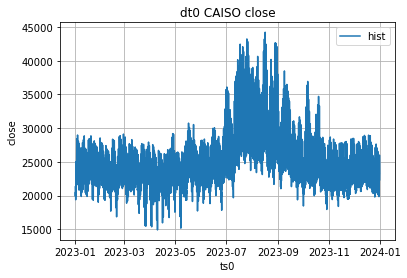

In [6]:
x0 = df1['ts0']
y0 = df1['close']
fig1, ax0 = plt.subplots()
sns.lineplot(x=x0,y=y0,label='hist')
plt.title(f'dt0 CAISO close')
plt.legend()
plt.grid()
plt.show()

### Seasonal Decomposition Modeling

In [10]:

#prd0 = 27
# NOTE hourly grain with seasonality to be estimated at a week. Guidance is to 
# set period to just above the cyclical/seasonal period. 
prd0 = 2*7*24+15

result = seasonal_decompose(df1['PGE'], model='addititve', period=prd0)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()
        
stl0 = STL(residual,period=prd0)
res1 = stl0.fit()
adf0 = adfuller(res1.resid)
adf1 = adfuller(res1.resid)[1] 
adf2 = str(adf1)[:4]
adf3 = str(adf1)[-4:]
adf4 = adf2 + adf3
ans4 = 'yes' if adf1 < 0.05 else 'no'
        
print(f'adf0 {adf0}')
print(f'adf1 {adf1}')
print(f'adf2 {adf2}')
print(f'adf3 {adf3}')
print(f'adf4 {adf4}')
print(f'period {prd0} p-val {adf4} : {ans4} <<< adfuller indicates that the residuals are stationary')
        

df_trend = trend.to_frame()
df_trend.columns = ['close']
df_trend.reset_index(inplace=True)




adf0 (-10.717948093992602, 3.2053101311417125e-19, 37, 8372, {'1%': -3.431131331360489, '5%': -2.8618852945896633, '10%': -2.5669537954518837}, 110638.26362644412)
adf1 3.2053101311417125e-19
adf2 3.20
adf3 e-19
adf4 3.20e-19
period 351 p-val 3.20e-19 : yes <<< adfuller indicates that the residuals are stationary


### Plot Original Timeseries, Trend, Seasonality & Residuals

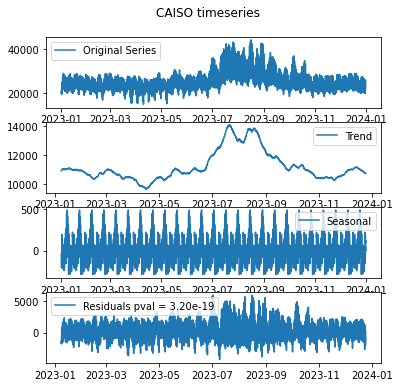

In [9]:
     
         
# Plot the decomposed components, make tics more readable
plt.figure(figsize=(6,6))
         
plt.subplot(4, 1, 1)
plt.plot(df1['CAISO'], label='Original Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label= f'Residuals pval = {adf4}')
plt.legend()

plt.suptitle(f'CAISO timeseries',y=.95)
plt.show()


In [15]:


def eda_4_caiso_arima(tic1,sho0,nam0,dt1,dt2,dt3):
    ''' TODO comment.

    TODO capstone read, undestand and apply vvv these.
    https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html
    https://stackoverflow.com/questions/66067471/how-to-choose-the-correct-arguments-of-statsmodels-stl-function


    '''
    tic1['lag1'] = tic1['close'].shift(1)
    tic1['del0'] = tic1['close']  - tic1['lag1']
    tic1['dt0']  = pd.to_datetime(tic1['dt0'])


    # NOTE!! use dropna() on series otherwise plot_acf won't work. fas1['del0'].dropna()
    tic2 = tic1.loc[:,['dt0','del0']].dropna()
    tic2.set_index(tic2['dt0'],inplace=True)
    tic2 = tic2.drop('dt0',axis=1) 


    #y_hist   = tic2.loc["2023-01-01":"2024-06-30"]
    #y_future = tic2.loc["2024-07-01":"2024-09-18"]
    y_hist   = tic2.loc[f'{dt1}':f'{dt2}']
    y_future = tic2.loc[f'{dt2}':f'{dt3}']
    y_future_len = (len(y_future))


    per0 = 50
    per1 = 100
    stl0  = STL(y_hist,period=per0)
    res0  = stl0.fit()
    stlf0 = STLForecast(y_hist,ARIMA,model_kwargs={
                    'order':(2,1,2), 'trend':'t'},period=per1)
    stlf_res0 = stlf0.fit()
    fcst0 = stlf_res0.forecast(y_future_len)


    df1 = pd.DataFrame(fcst0,columns=['fcst'])
    df1.insert(0, 'idx0', range(0, len(df1)))

    df2 = y_future.copy(deep=True)
    df2['dt1'] = df2.index
    df2.insert(0, 'idx0', range(0, len(df2)))

    df3 = pd.merge(df1,df2,on='idx0')

    y8 = 100 + 40
    y9 = 10
    x0 = tic1['dt0']
    y0 = tic1['del0'].cumsum() + y8

    x1 = df3['dt1']
    y1 = df3['del0'].cumsum() + y8
    y2 = df3['fcst'].cumsum() + y8 - y9

    #acf_lags = 7*24
    acf_lags = 24
    #acf_lags = 12

    del1 = tic2['del0'].dropna()
    fig0, ax0 = plt.subplots(figsize=(10,4))
    plot_pacf(del1,lags=acf_lags, ax=ax0, title='PACF y1')
    #plot_pacf(del1,lags=60, ax=ax0, title='ACF y1')
    #plot_pacf(del1,lags=24, ax=ax0, title='ACF y1')
    #plot_acf(del1,lags=60, ax=ax0, title='ACF y1')
    #plot_acf(del1, ax=ax0, title='ACF y1')
    plt.savefig(f'out/eda_4_0_{nam0}_pacf.png')
    if sho0: plt.show()

    fig2, ax0 = plt.subplots(figsize=(10,4))
    plot_acf(del1,lags=acf_lags, ax=ax0, title='ACF y1')
    #plot_pacf(del1,lags=60, ax=ax0, title='ACF y1')
    #plot_pacf(del1,lags=24, ax=ax0, title='ACF y1')
    #plot_acf(del1,lags=60, ax=ax0, title='ACF y1')
    #plot_acf(del1, ax=ax0, title='ACF y1')
    plt.savefig(f'out/eda_4_0_{nam0}_acf.png')
    if sho0: plt.show()

    #plot_acf(del1,lags=acf_lags, ax=ax0, title='ACF y1')

    #mse = float(mean_squared_error( geyser['duration'] ,geyser['waiting']))
    mse0 = round(float(mean_squared_error(y1,y2)),1)
    mae0 = round(float(mean_absolute_error(y1,y2)),1)
    #rmse0 = round(float(root_mean_squared_error(y1,y2)),1)

 
    plt.clf()
    plt.plot(res0.trend,    label='trend') 
    plt.plot(res0.seasonal, label='seasonal') 
    plt.plot(y_hist,        label='y_hist')
    plt.title(f'{nam0} STL hist with trend seasonal del0 ')
    plt.legend() 
    plt.savefig(f'out/eda_4_1_{nam0}.png')
    if sho0: plt.show()


    plt.clf()
    plt.plot(res0.resid,label='residual')
    plt.grid()
    plt.title(f'{nam0} Residuals - look for stationarity')
    plt.savefig(f'out/eda_4_2_{nam0}.png')
    if sho0: plt.show()


    plt.clf()
    plt.plot(y_future  ,label='actual future data')
    plt.plot(fcst0     ,label='forecast')
    plt.plot(y_hist    ,label='hist training data')
    plt.legend()
    plt.title(f'{nam0} STL Forecast with Future - del0')
    plt.grid()
    plt.savefig(f'out/eda_4_3_{nam0}.png')
    if sho0: plt.show()


    plt.clf()
    fig1, ax0 = plt.subplots()
    sns.lineplot(x=x0,y=y0,label='hist')
    sns.lineplot(x=x1,y=y1,label='actual')
    sns.lineplot(x=x1,y=y2,label='forecast')
    plt.title(f'{nam0} forecast with STL & ARIMA x0/y0. mse {mse0}')
    plt.legend()
    plt.grid()
    plt.savefig(f'out/eda_4_4_{nam0}.png')
    if sho0: plt.show()











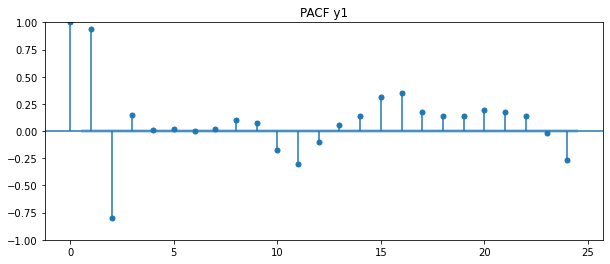

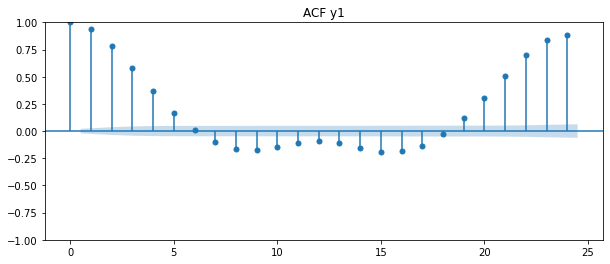

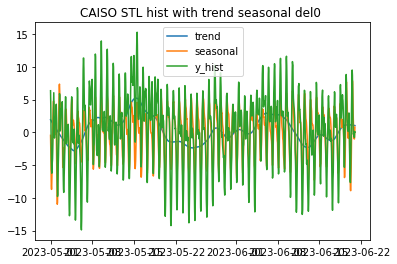

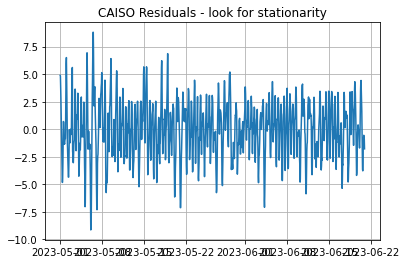

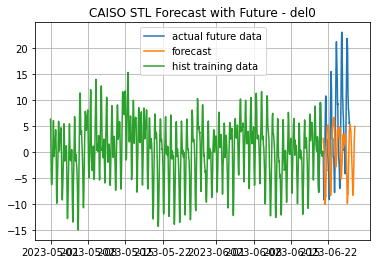

<Figure size 432x288 with 0 Axes>

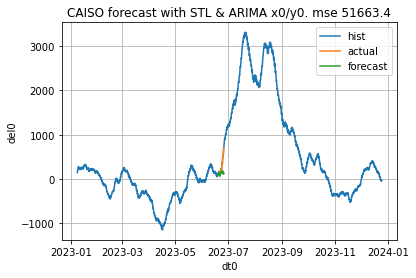

In [16]:


# NOTE recall that trend starts at 1/8/23 rather than 1/1 (it takes about
# 7 days for the trend and residuals to appear in the underlying data)
sho0 = True
nam0 = 'CAISO'
#self.eda_4_caiso_arima(df_trend,sho0,nam0,'2023-01-10','2023-01-15','2023-01-17')
#self.eda_4_caiso_arima(df_trend,sho0,nam0,'2023-02-10','2023-02-15','2023-02-17')
#self.eda_4_caiso_arima(df_trend,sho0,nam0,'2023-02-01','2023-02-05','2023-02-07')
#self.eda_4_caiso_arima(df_trend,sho0,nam0,'2023-06-01','2023-06-05','2023-06-07')
#self.eda_4_caiso_arima(df_trend,sho0,nam0,'2023-05-01','2023-06-08','2023-06-15')
#self.eda_4_caiso_arima(df_trend,sho0,nam0,'2023-05-01','2023-06-15','2023-06-22')
eda_4_caiso_arima(df_trend,sho0,nam0,'2023-05-01','2023-06-20','2023-06-25')


